<a href="https://colab.research.google.com/github/suneelbvs/rdkit_tutorials/blob/master/retrosynth_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparison of ASKCOS, molecule.one, and IBM RXN
**Jan Jensen, Unversity of Copenhagen**

The molecules are predicted binders to the covid protease Mpro, generated using a genetic algorithm by Casper Steinmann as described [here](https://colab.research.google.com/drive/1dDefhpk2hFEK1N6jFuVltd-f0VkJ7jBZ).

The link also gives some information about the ASKCOS settings, while the IBM RXN calculation are perfomed with [this notebook](https://colab.research.google.com/drive/1ip_SpZIWgJhYVxpFXxdj4J5Qlfy9Hkc7).

Note that the molecule set is not all that diverse.

#Install RDKit and retrieve data

In [ ]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [ ]:
%%bash
rm 8000top_ASKCOS.csv
wget https://www.dropbox.com/s/jtwv0vq9vnhwwxd/8000top_ASKCOS.csv

rm round1_moleculeone.json
wget https://www.dropbox.com/s/s6mrvttiggej0sd/round1_moleculeone.json

rm round1_ibm_rxn.csv
wget https://www.dropbox.com/s/yumbvz151mrdqi3/round1_ibm_rxn.csv

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd

In [ ]:
def canon(smiles):
  return Chem.MolToSmiles(Chem.MolFromSmiles(smiles))

#Round 1

##Combine data into dataframe

In [ ]:
df = pd.read_csv('8000top_ASKCOS.csv', usecols=["SMILES", "steps"])
df = df.rename(columns={"steps": "ASKCOS"})

round1_mol1 = pd.read_json (r'round1_moleculeone.json')
round1_mol1.rename(columns={"targetSmiles": "SMILES"}, inplace=True)
round1_mol1.rename(columns={"result": "MOL1"}, inplace=True)
df = pd.merge(df, round1_mol1, on=['SMILES'])
df.drop('status', axis = 1, inplace = True)
df.drop('reactionCount', axis = 1, inplace = True)

round1_ibm = pd.read_csv('round1_ibm_rxn.csv', usecols=["SMILES", "IBM"], delimiter=' ')

canon_smiles_list = [canon(x) for x in round1_ibm['SMILES'].tolist()]
round1_ibm.drop('SMILES', axis = 1, inplace = True)
round1_ibm['SMILES'] = canon_smiles_list

df = pd.merge(df, round1_ibm, on=['SMILES'])

The data set is not that diverse

There are 125 molecules in the data set

For example, 91 of these contain a urea-moiety

In [ ]:
print(df.shape[0])
mols = [Chem.MolFromSmiles(x) for x in df['SMILES'].tolist()]
patt = Chem.MolFromSmarts('NC(N)=O') #urea
print(len([m for m in mols if m.HasSubstructMatch(patt)]))

125
91


##number of molecules each program can make

In [ ]:
print(df.drop(df[(df.ASKCOS == 0)].index).shape, df.drop(df[(df.MOL1 == 10)].index).shape, df.drop(df[(df.IBM == 0.0)].index).shape)

(70, 4) (74, 4) (82, 4)


##molecules that can be made by all programs

In [ ]:
df.drop(df[(df.ASKCOS == 0) | (df.MOL1 == 10.0) | (df.IBM == 0.0)].index).shape

(62, 4)

##molecules that can be made by any one of the programs


In [ ]:
df.drop(df[(df.ASKCOS == 0) & (df.MOL1 == 10.0) & (df.IBM == 0.0)].index).shape

(90, 4)

## molecule that can't be made by any of the programs

Cyclopenta- and 1,3-cyclohexa-diene-type molecules

There are 35 of them

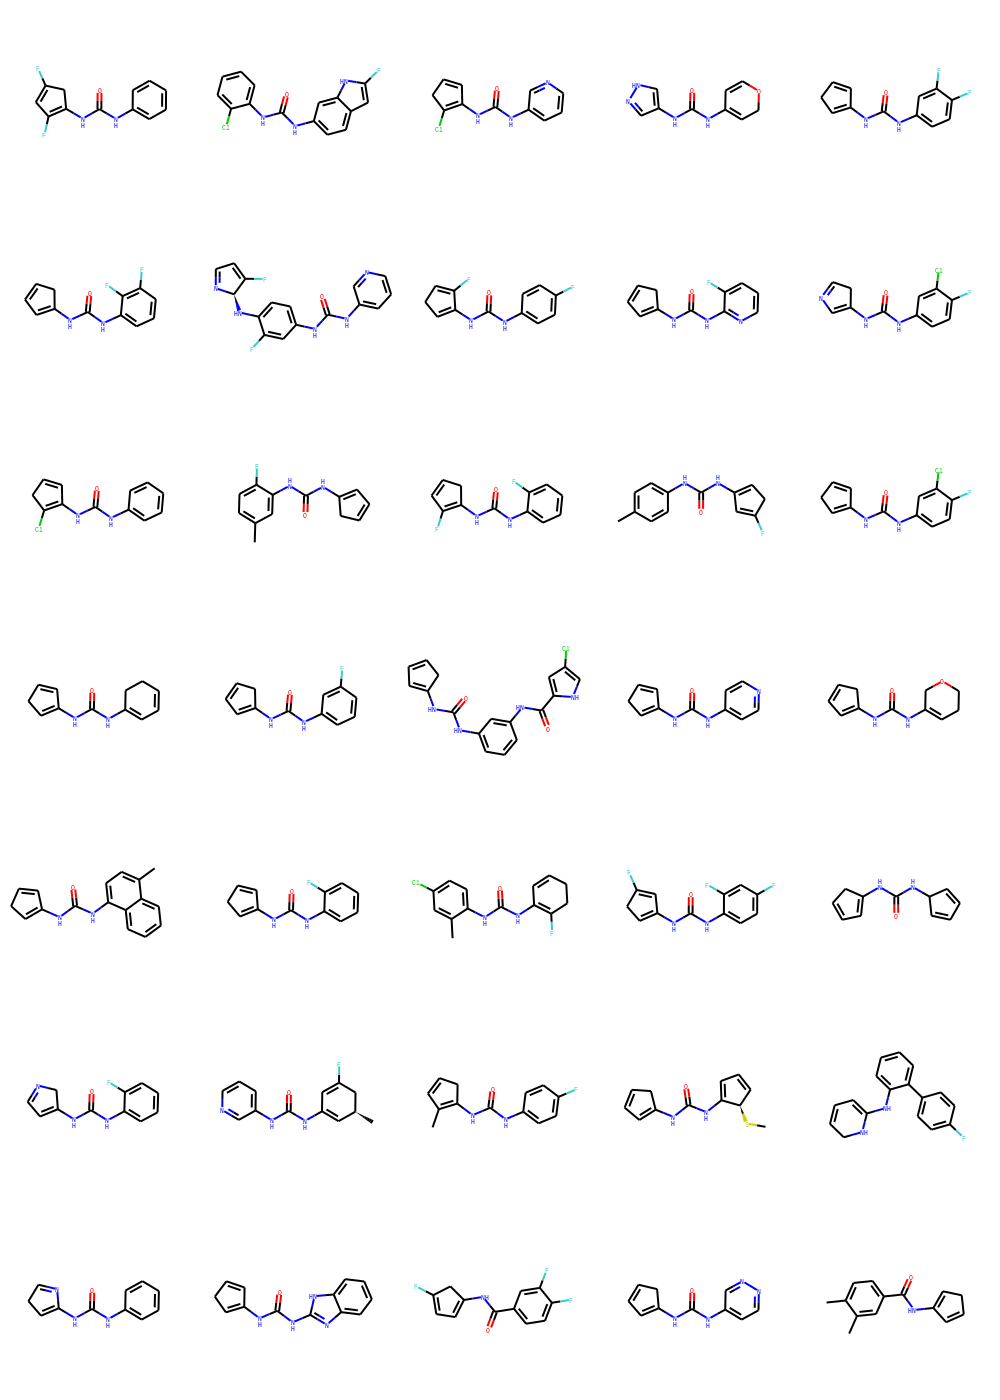

In [ ]:
smiles_list = df.drop(df[(df.ASKCOS != 0) | (df.MOL1 != 10.0) | (df.IBM != 0.0)].index)['SMILES'].tolist()
unsynth = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(unsynth,molsPerRow=5,legends=None,subImgSize=(200,200))

3 cyclopentadiene and 4 cyclohexadiene containing molecules can be made

In [ ]:
print('number of unsynthesizable molecules:',len(mols))
all = [Chem.MolFromSmiles(x) for x in df['SMILES'].tolist()]
patt = Chem.MolFromSmarts('C1=C[C,N]=CC1') #cyclopentadiene
print(len([m for m in all if m.HasSubstructMatch(patt)]),len([m for m in unsynth if m.HasSubstructMatch(patt)]))
patt = Chem.MolFromSmarts('[C,N]1[C,N]C=CC=C1') #cyclohexadiene
print(len([m for m in all if m.HasSubstructMatch(patt)]),len([m for m in unsynth if m.HasSubstructMatch(patt)]))

number of unsynthesizable molecules: 125
31 28
8 4


##molecules that can be made by ASKCOS but not by MOL1

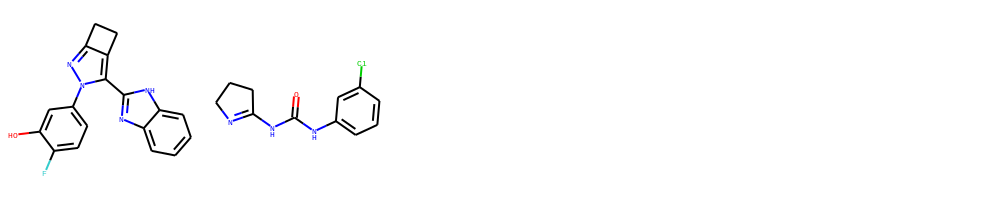

In [ ]:
smiles_list = df.drop(df[(df.ASKCOS == 0) | (df.MOL1 != 10.0)].index)['SMILES'].tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=None,subImgSize=(200,200))

##molecules that can be made by MOL1 but not by ASKCOS

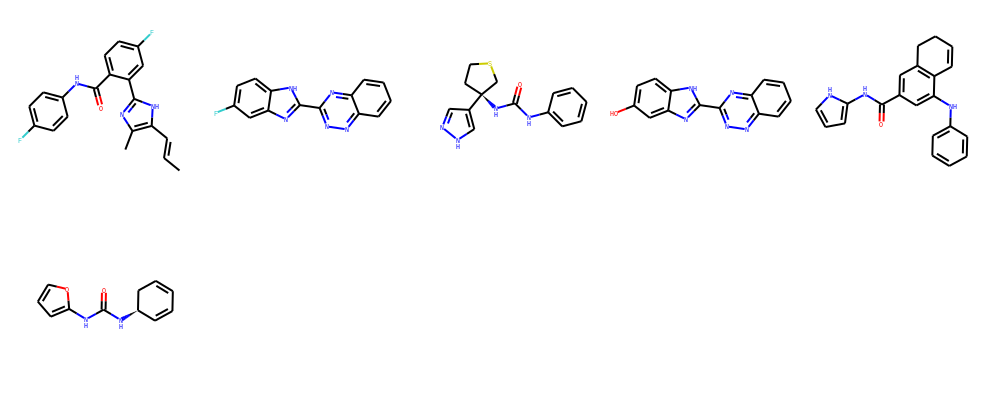

In [ ]:
smiles_list = df.drop(df[(df.ASKCOS != 0) | (df.MOL1 == 10.0)].index)['SMILES'].tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=None,subImgSize=(200,200))

##molecules that can be made by ASKOS but not IBM RXN

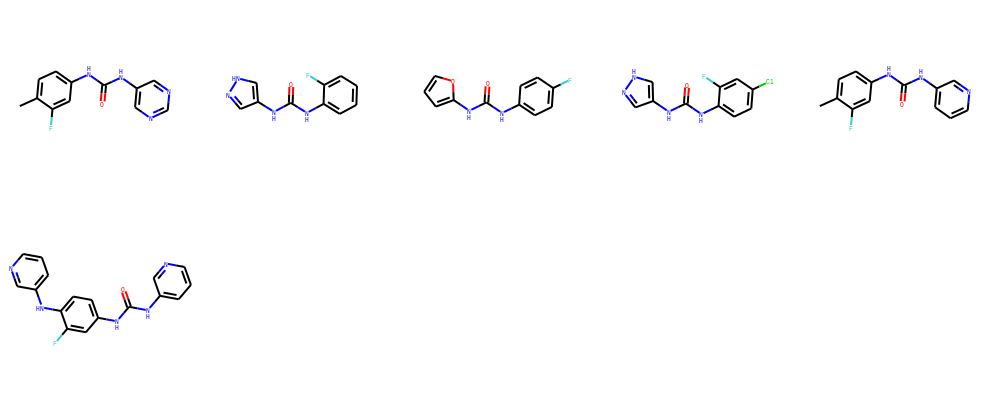

In [ ]:
smiles_list = df.drop(df[(df.ASKCOS == 0) | (df.IBM != 0.0)].index)['SMILES'].tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=None,subImgSize=(200,200))

##molecules that can be made by IBM RXN but not by ASKCOS

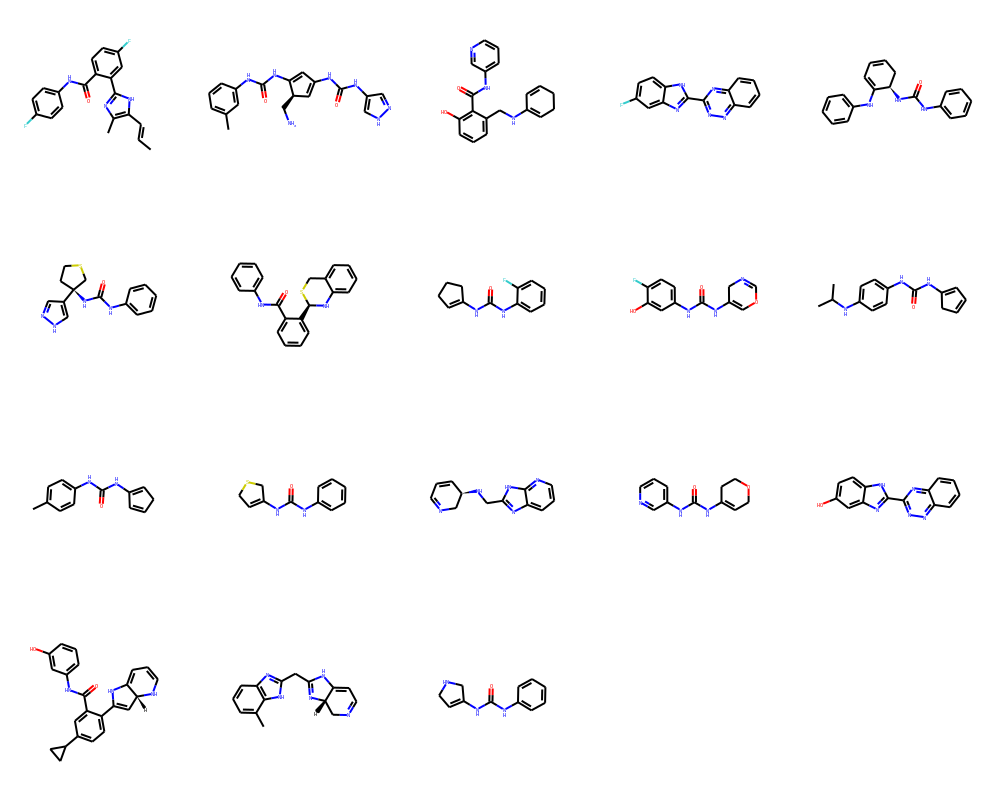

In [ ]:
smiles_list = df.drop(df[(df.ASKCOS != 0) | (df.IBM == 0.0)].index)['SMILES'].tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=None,subImgSize=(200,200))

##molecules that can be made by molecule.one but not by IBM RXN

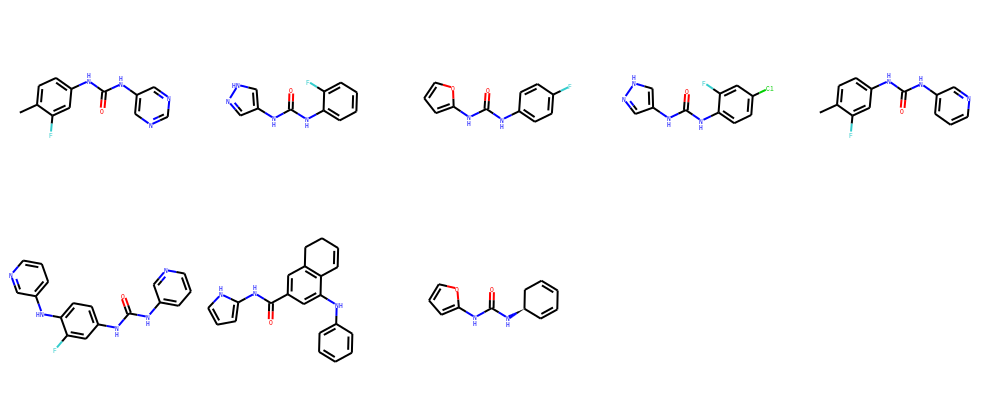

In [ ]:
smiles_list = df.drop(df[(df.MOL1 == 10) | (df.IBM != 0.0)].index)['SMILES'].tolist()
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=None,subImgSize=(200,200))

##molecules that can be made by IBM RXN but not by molecule.one

In [ ]:
df

,SMILES,ASKCOS,MOL1,IBM
0,Cc1cc(NC(=O)Nc2cn[nH]c2)cc(Cl)c1NC(=O)Nc1cn[nH]c1,4,3.547610,0.939
1,O=C(Nc1cccc(F)c1)Nc1cn[nH]c1F,3,3.792231,0.938
2,O=C(NC1=C(F)C=C(F)C1)Nc1ccccc1,0,10.000000,0.000
3,O=C(Nc1ccc(F)c(F)c1)Nc1cn[nH]c1F,3,3.791118,0.931
4,Clc1cccc2cccc(-c3nc4ccccc4[nH]3)c12,2,3.141658,0.979
...,...,...,...,...
120,O=C(NC1=CC=CC1)Nc1ccnnc1,0,10.000000,0.000
121,Cc1ccc(C(=O)NC2=CCC=C2)cc1C,0,10.000000,0.000
122,O=C(Nc1ccco1)N[C@H]1C=CC=CC1,0,7.365365,0.000
123,Cc1cc(NC(=O)Nc2cn[nH]c2)ccc1NC1CC1,2,2.893383,0.944


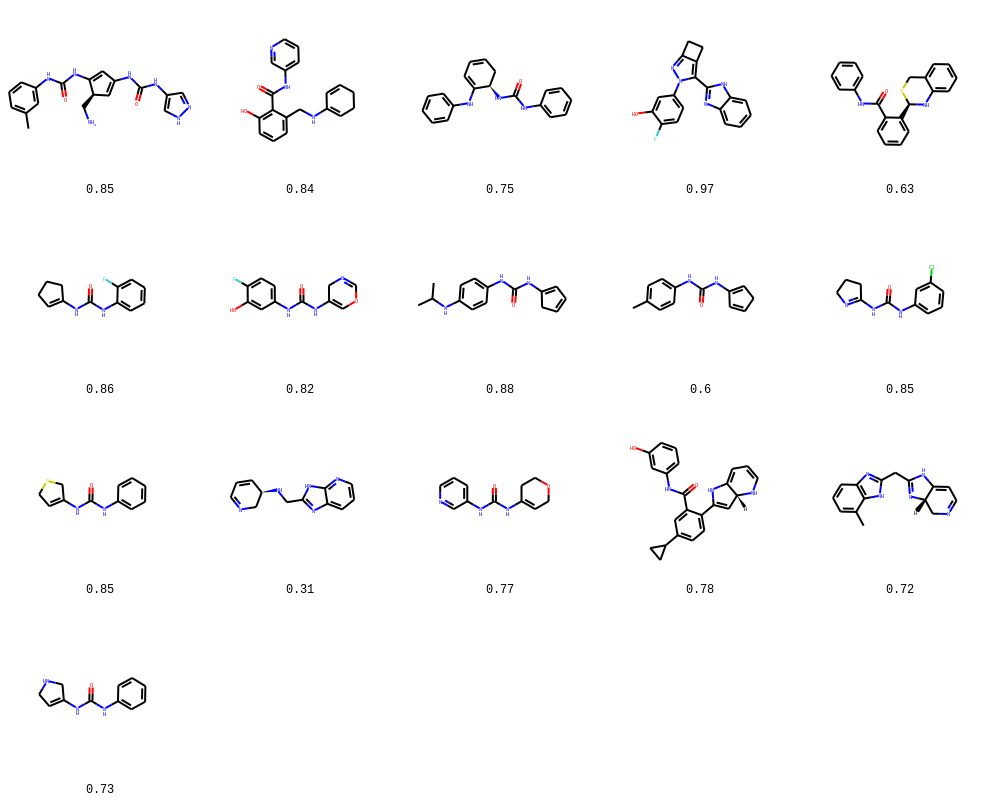

In [ ]:
smiles_list = df.drop(df[(df.MOL1 != 10) | (df.IBM == 0.0)].index)['SMILES'].tolist()
labels = df.drop(df[(df.MOL1 != 10) | (df.IBM == 0.0)].index)['IBM'].tolist()
labels = [str(round(x,2)) for x in labels]
mols = [Chem.MolFromSmiles(x) for x in smiles_list]
Draw.MolsToGridImage(mols,molsPerRow=5,legends=labels,subImgSize=(200,200))